In [248]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from tensorflow.keras import layers, utils, losses, models as mds, optimizers
from visualkeras import layered_view

if imp.find_loader('aggdraw'): import aggdraw
if imp.find_loader('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers

In [111]:
IMG_SIZE = 264
N_CLASSES = 102

In [245]:
def sic_block(input_tensor, filters, strides, padding, activation):
    def variant_dims(size):
        n_variants = ceil(log(ceil(sqrt(size)), pi))
        return list(map(lambda x: 3**x, range(1, n_variants+1)))

    def make_layer(size):
        kwargs = dict(strides=strides, padding=padding)
        return layers.Conv2D(filters, size, **kwargs)

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    conv_layers = map(make_layer, variants)
    conv_outputs = list(map(lambda x: x(input_tensor), conv_layers))
    merged = tf.concat(conv_outputs, axis=-1)
    normalized = layers.BatchNormalization()(merged)
    output = layers.Activation(activation)(normalized)

    return output

conv_id = -1

def increment_conv_id():
    global conv_id
    conv_id += 1

    return conv_id

def conv_block(filters, **kwargs):
    return tf.keras.Sequential([
            layers.Conv2D(filters, 3, **kwargs),
            layers.BatchNormalization(),
        ],
        name='conv_block_' + str(increment_conv_id()))

def attentive_merge(q, v):
    return layers.Attention()([q, v])

def multi_level_merge(q, vs):
    format = lambda t: layers.Reshape([-1, t.shape[-1]])(t)
    unformat = lambda t,s: layers.Reshape(s[1:])(t)

    # output = reduce(lambda y,x: layers.Attention()([y, format(x)]), qs, format(v))
    output = reduce(lambda y,x: attentive_merge(y, format(x)), vs, format(q))

    v = unformat(output, q.shape)
    return v

def assemble_backbone(input_tensor, depth, skip_rates, heat=1, chill=1, reheat=8, skip_start_depth=7):
    # Alternate 2 and 1 strides
    strides = list(map(lambda x: 2 if x%(heat+chill) == 0 else 1, range(depth)))

    # Create Convolution Blocks
    kwargs = dict(padding='same', activation='relu')
    blocks = list(map(lambda x: conv_block(64, strides=x, **kwargs), strides))
    block_outputs = [None] * len(blocks)

    # Compute skip connections
    skip_levels = list(map(lambda sr: list(range(0, depth, sr)), skip_rates))
    skip_connections = [[] for _ in range(depth)]

    for sl in skip_levels:
        for x in range(1, len(sl)):
            skip_connections[sl[x]].append(sl[x-1])

    def join_skips(idx, skips):
        skip_outputs = list(map(lambda x: block_outputs[x], skips))
        block_input =  multi_level_merge(block_outputs[idx-1], skip_outputs)
        return blocks[idx](block_input)
    
    def apply_reheat(idx, x):
        filters, name = x.shape[-1], 'conv_transpose_' + str(increment_conv_id())
        x = layers.Conv2DTranspose(filters, 3, strides=2, name=name)(x)
        block_outputs[idx-1] = x
        return x
    
    for idx, block in enumerate(blocks):
        skips = skip_connections[idx]

        # Deconv to increase dimensionality
        input_tensor = apply_reheat(idx, input_tensor) if idx and not idx%reheat else input_tensor

        join_cond = skips and idx >= skip_start_depth
        input_tensor = join_skips(idx, skips) if join_cond else block(input_tensor)
        block_outputs[idx] = input_tensor
    
    return input_tensor
    
def create_model(depth=60, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=2, reheat=7, skip_start_depth=10):
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = assemble_backbone(inp, depth, skips, heat, chill, reheat, skip_start_depth)
    x = layers.Flatten()(x)
    output = layers.Dense(N_CLASSES, activation='softmax')(x)
    m = tf.keras.Model(inputs=inp, outputs=output)

    m.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics='accuracy')

    return m

model = create_model()
utils.plot_model(model, show_shapes=True)

In [246]:
model.summary()

Model: "model_85"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_157 (InputLayer)         [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_0 (Sequential)      (None, 132, 132, 64  2048        ['input_157[0][0]']              
                                )                                                                 
                                                                                                  
 conv_block_1 (Sequential)      (None, 132, 132, 64  37184       ['conv_block_0[0][0]']           
                                )                                                          

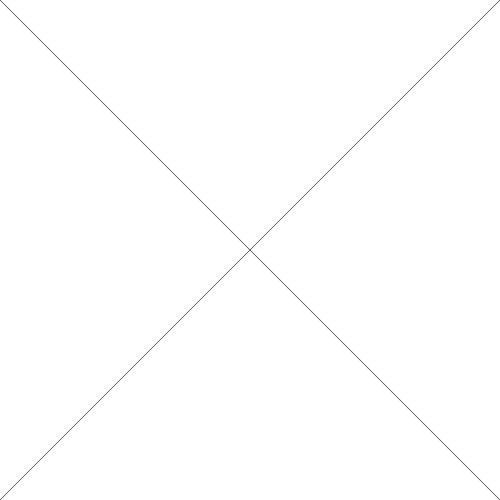